In [9]:
import glob
import os
import numpy as np
import pickle
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from skimage.filters import gabor_kernel
from skimage import io
from skimage.transform import resize
from scipy import stats
# from numpy.linalg import inv
import math

In [10]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
    gabor = gauss * sinusoid
    return gabor

# Example filter
g = genGabor((100,100), 0.3, 105*(np.pi/180.0), func=np.cos) 
#plt.imshow(g, cmap='gray')

In [11]:
# Parameters for generating gabor filters
phase_offset = 90
patch_size = 21
theta_list = np.linspace(0, 165, 12)
#theta_list = np.linspace(0, 160, 9)
#theta_list = np.linspace(0, 175, 36)
print("Orientation to consider {}: {}".format(len(theta_list), theta_list))

Orientation to consider 12: [  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165.]


(21, 252)


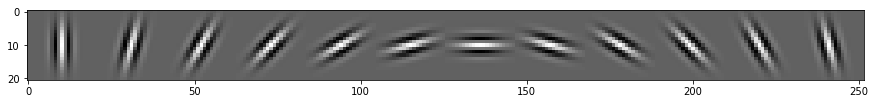

In [12]:
# 2D filter bank using Gabor function
gabor_bank = []
for ii in range(0, len(theta_list)):
    g_kernel = genGabor((100,100), 0.3, theta_list[ii]*(np.pi/180.0), func=np.cos) 
    g_kernel = resize(g_kernel, (patch_size, patch_size))
    gabor_bank.append(np.array(g_kernel))

image_filter = np.concatenate(gabor_bank, axis=1)
print(image_filter.shape)
plt.imshow(image_filter, cmap='gray')
figure = plt.gcf()
figure.set_size_inches(15, 15)

In [13]:
# 1D (flatten) filter bank for normalized dot product
filt_flatten = []
for i in range(len(theta_list)):
    patch = gabor_bank[i]
    patch = np.ndarray.flatten(patch)
    patch = (patch-np.mean(patch)) / (np.std(patch) + 1e-5)
    #patch = patch / np.linalg.norm(patch)
    filt_flatten.append(patch)

filt_flatten = np.vstack(filt_flatten)

In [14]:
def get_filter_map(imm, filt_flatten):
    f_map = np.zeros((imm.shape[0]-patch_size+1, imm.shape[1]-patch_size+1, len(gabor_bank)))
    #f_map = np.zeros(2,2,len(gabor_bank))
    for i in range(imm.shape[0]-patch_size+1):
        for j in range(2):#imm.shape[1]-patch_size+1):
            patch = imm[i:i+patch_size, j:j+patch_size]
            print(patch)
            patch = np.ndarray.flatten(patch)
            patch = (patch-np.mean(patch)) / (np.std(patch) + 1e-5)
            #patch = patch / np.linalg.norm(patch)
            for k in range(len(gabor_bank)):
                f_map[i,j,k] = np.dot(patch, filt_flatten[k])
    return f_map

In [15]:
def normalize_conn(stat_save):
    all_modes = np.zeros((25, 12))
    all_strng = np.zeros((25, 12))
    for i in range(12):
        for j in range(25):
            temp = stat_save[j][i]
            nn = np.argmax(temp)
            all_modes[j,i] = nn
            all_strng[j,i] = temp[nn] / np.sum(temp)
    all_modes = all_modes.astype(int)
    all_strng[1:] = (all_strng[1:] - all_strng[1:].min()) / (all_strng[1:].max() - all_strng[1:].min())
    return all_modes, all_strng

Figure for radius = 1


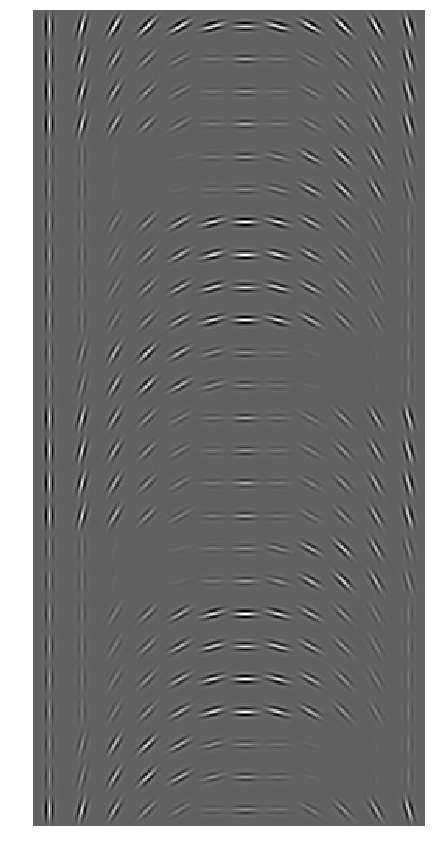

In [16]:
list_rad = [1]
tempp = np.zeros((25,12,12))
for ll in range(len(list_rad)):
    fname = "./multipl_xy_12_winner/rad1xy_winner.pkl"
    
    with open(fname,'rb') as f:
        stat_save = pickle.load(f)
        
    
    all_modes, all_strng = normalize_conn(stat_save)
    
    for i in range(12):
        all_strng[:,i] = all_strng[:,i] / all_strng[0,i]

    hor_mat_list = []
    for ii in range(0, all_modes.shape[0]):
        #print('ii', ii)
        temp_var = []
        for jj in range(all_modes.shape[1]):
            #print('jj',jj)
            #print(all_strng[ii,jj]*gabor_bank[all_modes[ii,jj]])
            temp_var.append(all_strng[ii,jj]*gabor_bank[all_modes[ii,jj]])
        temp_var = np.concatenate(temp_var, axis=1)
        hor_mat_list.append(temp_var)
    
    print("Figure for radius = {}".format(list_rad[ll]))
    image_filter = np.concatenate(hor_mat_list, axis=0)
    plt.imshow(image_filter, cmap='gray')
    plt.axis('off')
    figure = plt.gcf()
    figure.set_size_inches(15, 15)
    plt.savefig("./MapFigs/arrangement_36_winner" + str(list_rad[ll]) + ".png", bbox_inches='tight')
    plt.show()